## The Task: A Simple Grid World

###  Environment Setup
We'll use a 10x10 grid. The agent starts at `(0,0)` and needs to reach `(9,9)`. This simple setup allows us to clearly see states, actions, and their consequences.

### States, Actions, Rewards Defined
- **State:** Agent's `(row, col)` tuple.
- **Actions:** 4 discrete actions: 0 (Up), 1 (Down), 2 (Left), 3 (Right).
- **Transitions:** Deterministic. Taking action 'Up' from `(r, c)` leads to `(r-1, c)` unless `r=0` (wall).
- **Rewards:**
    - +10: Reaching the goal `(9, 9)`.
    - -1: Bumping into a wall (moving off-grid).
    - -0.1: Taking any other step.
- **Episode End:** Reaching the goal or exceeding a step limit.

##  Our Simple "Learning" Agent: MemoryBot

### Agent's Goal vs. True RL Goal
A true RL agent aims to maximize the *cumulative discounted reward*. Our simple 'MemoryBot' agent will have a much simpler objective: it will try to pick actions that have led to high *average immediate rewards* from the current state in the past. It has no concept of future rewards or discounting. This highlights the difference between basic memory and true value-based learning.

###  The Agent's Memory Structure
We'll use a nested dictionary: `memory[state][action] -> list_of_rewards`.
- `state` is a `(row, col)` tuple.
- `action` is an integer (0-3).
- `list_of_rewards` stores all the immediate rewards received *immediately after* taking that `action` from that `state`.

### The Agent's Simple Policy (Strategy)
$\epsilon$-greedy based on average immediate reward:
1.  Generate a random number `rand` between 0 and 1.
2.  If `rand < epsilon`: Choose a random action (0, 1, 2, or 3).
3.  If `rand >= epsilon`:
    a.  For the current state `s`, calculate the average immediate reward for each possible action `a`: `AvgR(s, a) = mean(memory[s][a])` (treat empty lists as having an average of 0 or a very small negative number).
    b.  Find the action(s) `a*` with the highest `AvgR(s, a*)`.
    c.  Choose one of these best actions randomly (to break ties).

###  The Agent's "Learning" Process (Memory Update)
This is just bookkeeping:
- After taking action $a_t$ in state $s_t$ and receiving reward $r_t$, simply append $r_t$ to the list `memory[s_t][a_t]`.

##  Setting up the Simulation Environment

###  Importing Libraries
Import the necessary Python libraries.

In [1]:
# Import necessary libraries
import numpy as np # For numerical operations (like mean)
import matplotlib.pyplot as plt # For plotting results
import random # For random choices (exploration, tie-breaking)
from collections import defaultdict # Convenient for creating nested dictionaries for memory
from typing import Tuple, Dict, List, DefaultDict, Any # For type hinting

# Set random seeds for reproducibility
seed: int = 42
random.seed(seed)
np.random.seed(seed)

# Enable inline plotting for Jupyter Notebook
%matplotlib inline

print("Libraries imported and seeds set.")

Libraries imported and seeds set.


### 4.2 Environment Class Implementation
Define the Grid World environment class. We add comments explaining each part.

In [2]:
class GridEnvironmentSimple:
    """
    Basic Grid World environment for demonstrating RL concepts.
    States are (row, col) tuples. Actions are integers 0-3.
    """
    def __init__(self, rows: int = 10, cols: int = 10) -> None:
        """ Initialize the grid environment. """
        self.rows: int = rows # Number of rows
        self.cols: int = cols # Number of columns
        self.start_state: Tuple[int, int] = (0, 0) # Agent starts at top-left
        self.goal_state: Tuple[int, int] = (rows - 1, cols - 1) # Goal at bottom-right
        self.state: Tuple[int, int] = self.start_state # Agent's current position
        # Define action mapping: 0=Up, 1=Down, 2=Left, 3=Right
        self.action_map: Dict[int, Tuple[int, int]] = {
            0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)
        }
        self.actions: List[int] = list(self.action_map.keys()) # List of possible action indices
        self.action_dim: int = len(self.actions) # Number of possible actions
        print(f"[Env] Initialized {rows}x{cols} grid. Start: {self.start_state}, Goal: {self.goal_state}")

    def reset(self) -> Tuple[int, int]:
        """ Resets the agent to the start state. Returns the initial state. """
        self.state = self.start_state
        # print(f"[Env] Reset to state: {self.state}") # Debug
        return self.state

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool]:
        """
        Executes an action, updates the state, and returns the outcome.

        Returns:
            (next_state, reward, done)
        """
        # If already at goal, episode effectively ends (return current state, 0 reward, True)
        if self.state == self.goal_state:
            # print(f"[Env] Already at goal {self.state}. No action taken.") # Debug
            return self.state, 0.0, True

        # Get state change from action map
        dr, dc = self.action_map[action]
        current_row, current_col = self.state

        # Calculate potential new position
        next_row, next_col = current_row + dr, current_col + dc

        # Default reward is the step cost
        reward: float = -0.1

        # Check boundaries (walls)
        if not (0 <= next_row < self.rows and 0 <= next_col < self.cols):
            # Hit wall: state doesn't change, reward is penalty
            next_state_tuple = self.state
            reward = -1.0
            # print(f"[Env] Wall hit at {self.state} trying action {action}. Next state: {next_state_tuple}, Reward: {reward}") # Debug
        else:
            # Valid move: update internal state
            self.state = (next_row, next_col)
            next_state_tuple = self.state
            # print(f"[Env] Moved from {(current_row, current_col)} via action {action} to {self.state}. Reward: {reward}") # Debug

        # Check if the new state is the goal
        done: bool = (self.state == self.goal_state)
        if done:
            reward = 10.0 # Assign goal reward
            # print(f"[Env] Goal reached! State: {self.state}. Reward: {reward}, Done: {done}") # Debug

        # Return the outcome: new state, reward, done flag
        return next_state_tuple, reward, done

    def get_action_space_size(self) -> int:
        """ Returns the number of possible actions. """
        return self.action_dim

### 4.3 Instantiating the Environment
Create an instance of our grid world.

In [3]:
# Create the environment instance
simple_env: GridEnvironmentSimple = GridEnvironmentSimple(rows=10, cols=10)
# Get the number of possible actions from the environment
n_actions_simple: int = simple_env.get_action_space_size()

[Env] Initialized 10x10 grid. Start: (0, 0), Goal: (9, 9)


## 5. Implementing the Simple Agent's Logic

Implement the functions for memory, action selection, and learning (memory update).

### 5.1 Initializing Agent Memory
We use `defaultdict` for convenience. If we access `memory[state]` and it doesn't exist, it automatically creates a new `defaultdict(list)`. If we access `memory[state][action]` and it doesn't exist, it automatically creates an empty `list`.

In [4]:
# Agent's memory: Stores lists of immediate rewards.
# Key: state tuple (r, c)
# Value: Another defaultdict where Key: action index (0-3), Value: List of rewards [float]
agent_memory: DefaultDict[Tuple[int, int], DefaultDict[int, List[float]]] = \
    defaultdict(lambda: defaultdict(list))

print("Agent memory initialized.")
print(f"Example memory access for unvisited state (0,1), action 0: {agent_memory[(0,1)][0]}")

Agent memory initialized.
Example memory access for unvisited state (0,1), action 0: []


### 5.2 Choosing an Action (Epsilon-Greedy based on Immediate Reward)
This function implements the agent's policy $\pi(a|s)$.

In [5]:
def choose_simple_action(state: Tuple[int, int],
                           memory: DefaultDict[Tuple[int, int], DefaultDict[int, List[float]]],
                           epsilon: float,
                           n_actions: int) -> int:
    """
    Chooses action using epsilon-greedy based on average immediate rewards in memory.
    """
    # Decide whether to explore or exploit
    if random.random() < epsilon:
        # --- Exploration ---
        action: int = random.randrange(n_actions) # Choose a random action index (0, 1, 2, or 3)
        # print(f"  -> Exploring: Random action = {action}") # Debug
        return action
    else:
        # --- Exploitation ---
        # Calculate the average reward remembered for each possible action from the current state
        avg_rewards_for_actions: List[float] = []
        state_action_memory: DefaultDict[int, List[float]] = memory[state]

        for a in range(n_actions):
            rewards_list: List[float] = state_action_memory[a]
            if not rewards_list: # If we have no memory for this action in this state
                avg_reward: float = 0.0 # Assign a default value (could be negative)
            else:
                avg_reward = np.mean(rewards_list) # Calculate the average of remembered rewards
            avg_rewards_for_actions.append(avg_reward)

        # Find the highest average reward among all actions
        max_avg_reward: float = max(avg_rewards_for_actions)

        # Get a list of all actions that achieve this maximum average reward
        best_actions: List[int] = [a for a, avg_r in enumerate(avg_rewards_for_actions) if avg_r == max_avg_reward]

        # Randomly choose one action from the best actions (breaks ties)
        action = random.choice(best_actions)
        # print(f"  -> Exploiting: Avg Rewards={avg_rewards_for_actions}, Best Action(s)={best_actions}, Chosen={action}") # Debug
        return action

### 5.3 Updating Agent Memory
This function represents the agent's simple "learning" process.

In [6]:
def update_simple_memory(memory: DefaultDict[Tuple[int, int], DefaultDict[int, List[float]]],
                           state: Tuple[int, int],
                           action: int,
                           reward: float) -> None:
    """
    Updates the agent's memory by adding the received immediate reward.
    """
    # Access the list of rewards for the specific state-action pair and append the new reward
    memory[state][action].append(reward)
    # print(f"  -> Memory Updated: State={state}, Action={action}, Added Reward={reward:.1f}, New Memory for Action: {memory[state][action]}") # Debug

# 6. Running the Simulation Loop

We simulate the agent interacting with the environment over multiple episodes.

### 6.1 Simulation Parameters

In [7]:
# Simulation Hyperparameters
NUM_EPISODES: int = 1000
MAX_STEPS_PER_EPISODE: int = 150
EPSILON_START_SIM: float = 1.0  # Start with fully random exploration
EPSILON_END_SIM: float = 0.01   # Keep a small chance of exploration
EPSILON_DECAY_SIM: float = 0.99 # Decay rate per episode (e.g., 0.99 means epsilon becomes 99% of its previous value)
PRINT_EVERY_N_EPISODES: int = 100 # How often to print progress

### 6.2 Initialization for the Run

In [8]:
# Create environment instance for the simulation run
env_run: GridEnvironmentSimple = GridEnvironmentSimple(rows=10, cols=10)
n_actions_run: int = env_run.get_action_space_size()

# Initialize Agent Memory for this run
agent_memory_run: DefaultDict[Tuple[int, int], DefaultDict[int, List[float]]] = \
    defaultdict(lambda: defaultdict(list))

# Initialize lists to store results for plotting
simple_episode_rewards: List[float] = []
simple_episode_lengths: List[int] = []
simple_episode_epsilons: List[float] = []

# Initialize exploration rate for this run
current_epsilon_run: float = EPSILON_START_SIM

print("Simulation setup complete.")

[Env] Initialized 10x10 grid. Start: (0, 0), Goal: (9, 9)
Simulation setup complete.


### 6.3 The Main Simulation Loop (Detailed Steps)
The agent interacts with the environment episode by episode.

In [9]:
print(f"Starting Simple Agent Simulation for {NUM_EPISODES} episodes...")

# Loop over the specified number of episodes
for i_episode in range(1, NUM_EPISODES + 1):

    # --- Start of Episode ---
    # Reset the environment to get the starting state
    current_state: Tuple[int, int] = env_run.reset()
    # Reset episode-specific trackers
    current_episode_reward: float = 0.0

    # print(f"\n--- Episode {i_episode} Start | Epsilon: {current_epsilon_run:.3f} ---") # Debug

    # Loop for each step within the episode, up to the maximum allowed steps
    for t in range(MAX_STEPS_PER_EPISODE):

        # print(f" Step {t+1}: State={current_state}") # Debug

        # 1. Agent chooses an action
        action: int = choose_simple_action(
            current_state,
            agent_memory_run,
            current_epsilon_run,
            n_actions_run
        )

        # 2. Agent takes action in the environment
        next_state, reward, done = env_run.step(action)
        # print(f"   Action={action}, Reward={reward:.1f}, NextState={next_state}, Done={done}") # Debug

        # 3. Agent updates its memory (learns from immediate reward)
        update_simple_memory(agent_memory_run, current_state, action, reward)

        # Update the state for the next time step
        current_state = next_state
        # Add the received reward to the episode's total reward
        current_episode_reward += reward

        # Check if the episode terminated (goal reached or maybe other conditions)
        if done:
            # print(f" Episode {i_episode} finished at step {t+1}. Goal Reached.") # Debug
            break # Stop the current episode

    # --- End of Episode ---
    # If the loop finished because MAX_STEPS was reached
    # if not done:
        # print(f" Episode {i_episode} finished at step {t+1}. Max steps reached.") # Debug

    # Store results for this episode
    simple_episode_rewards.append(current_episode_reward)
    simple_episode_lengths.append(t + 1) # t is the last step index, so length is t+1
    simple_episode_epsilons.append(current_epsilon_run)

    # Decay epsilon for the next episode
    current_epsilon_run = max(EPSILON_END_SIM, current_epsilon_run * EPSILON_DECAY_SIM)

    # Print progress summary periodically
    if i_episode % PRINT_EVERY_N_EPISODES == 0:
        avg_reward = np.mean(simple_episode_rewards[-PRINT_EVERY_N_EPISODES:])
        avg_length = np.mean(simple_episode_lengths[-PRINT_EVERY_N_EPISODES:])
        print(f"Episode {i_episode}/{NUM_EPISODES} | Avg Reward (last {PRINT_EVERY_N_EPISODES}): {avg_reward:.2f} | Avg Length: {avg_length:.1f} | Epsilon: {current_epsilon_run:.3f}")

print(f"\nSimple Agent Simulation Finished after {NUM_EPISODES} episodes.")

Starting Simple Agent Simulation for 1000 episodes...
Episode 100/1000 | Avg Reward (last 100): -20.71 | Avg Length: 144.0 | Epsilon: 0.366
Episode 200/1000 | Avg Reward (last 100): -17.11 | Avg Length: 148.6 | Epsilon: 0.134
Episode 300/1000 | Avg Reward (last 100): -14.65 | Avg Length: 144.3 | Epsilon: 0.049
Episode 400/1000 | Avg Reward (last 100): -15.26 | Avg Length: 149.7 | Epsilon: 0.018
Episode 500/1000 | Avg Reward (last 100): -15.07 | Avg Length: 149.7 | Epsilon: 0.010
Episode 600/1000 | Avg Reward (last 100): -11.95 | Avg Length: 136.8 | Epsilon: 0.010
Episode 700/1000 | Avg Reward (last 100): -10.14 | Avg Length: 127.4 | Epsilon: 0.010
Episode 800/1000 | Avg Reward (last 100): -11.02 | Avg Length: 133.2 | Epsilon: 0.010
Episode 900/1000 | Avg Reward (last 100): -13.35 | Avg Length: 141.3 | Epsilon: 0.010
Episode 1000/1000 | Avg Reward (last 100): -7.49 | Avg Length: 110.5 | Epsilon: 0.010

Simple Agent Simulation Finished after 1000 episodes.


# 7. Visualizing the Results

Plotting helps understand how the agent's performance changed over time.

### 7.1 Basic Performance Metrics

#### 7.1.1 Episode Rewards Over Time

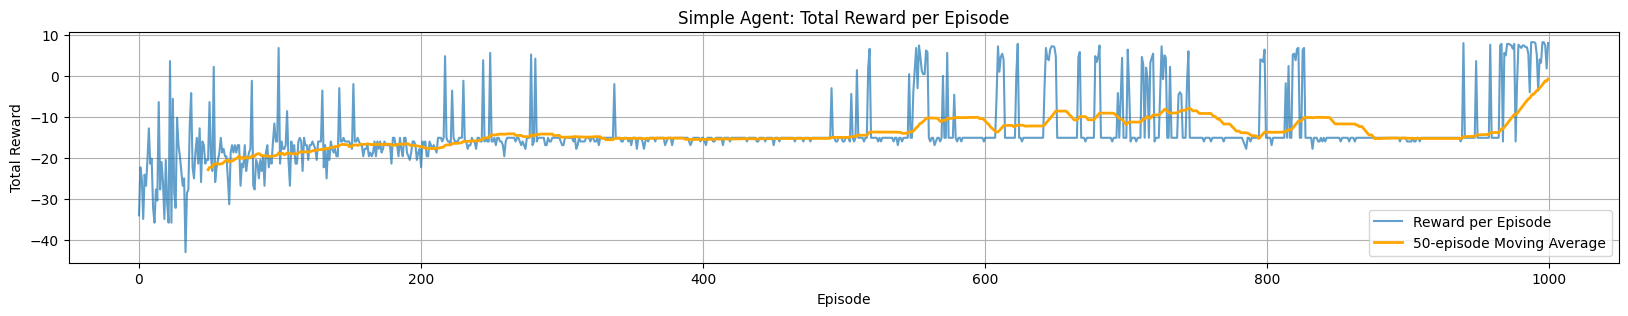

In [10]:
# Plotting episode rewards
plt.figure(figsize=(20, 3))
plt.plot(simple_episode_rewards, label='Reward per Episode', alpha=0.7)
plt.title('Simple Agent: Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)

# Calculate and plot moving average
window_size = 50
if len(simple_episode_rewards) >= window_size:
    # Use numpy's convolve for moving average
    rewards_ma = np.convolve(simple_episode_rewards, np.ones(window_size)/window_size, mode='valid')
    # Adjust x-axis for moving average plot
    plt.plot(np.arange(len(rewards_ma)) + window_size - 1, rewards_ma,
             label=f'{window_size}-episode Moving Average', color='orange', linewidth=2)

plt.legend()
plt.show()

**Interpretation:** This plot shows the total reward collected by the agent in each episode. A noisy line is expected due to exploration and randomness. The orange line (moving average) smooths this out, showing the general trend. If the agent is learning effectively (even with its simple strategy), we expect the moving average to trend upwards, indicating it's getting higher scores over time (reaching the goal more often or faster, avoiding walls more).

#### 7.1.2 Episode Lengths Over Time

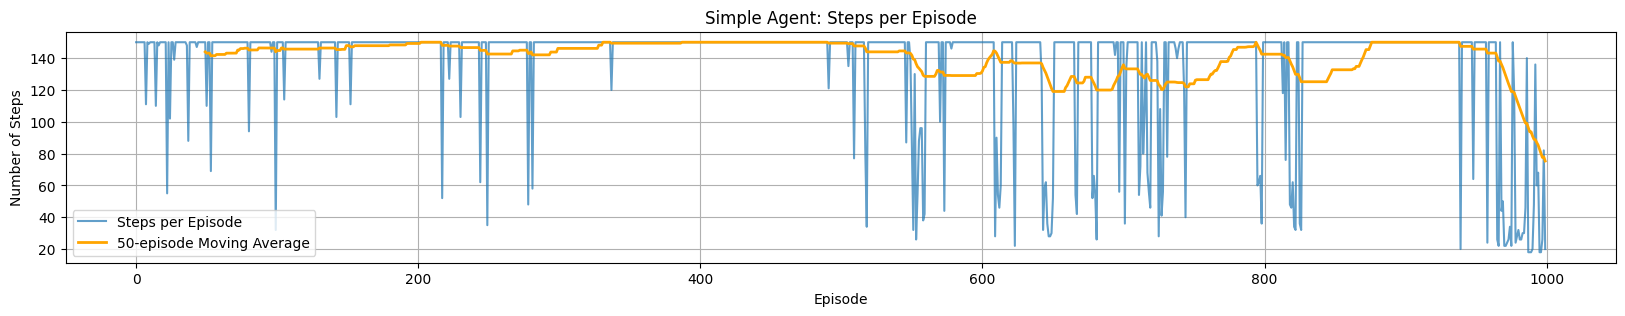

In [11]:
# Plotting episode lengths
plt.figure(figsize=(20, 3))
plt.plot(simple_episode_lengths, label='Steps per Episode', alpha=0.7)
plt.title('Simple Agent: Steps per Episode')
plt.xlabel('Episode')
plt.ylabel('Number of Steps')
plt.grid(True)

# Calculate and plot moving average
window_size = 50
if len(simple_episode_lengths) >= window_size:
    lengths_ma = np.convolve(simple_episode_lengths, np.ones(window_size)/window_size, mode='valid')
    plt.plot(np.arange(len(lengths_ma)) + window_size - 1, lengths_ma,
             label=f'{window_size}-episode Moving Average', color='orange', linewidth=2)
    plt.legend()

plt.show()

**Interpretation:** This plot shows how many steps it took the agent to complete each episode. If the agent learns to reach the goal more efficiently, the number of steps should decrease over time. A downward trend in the moving average indicates improved efficiency.

#### 7.1.3 Epsilon Decay

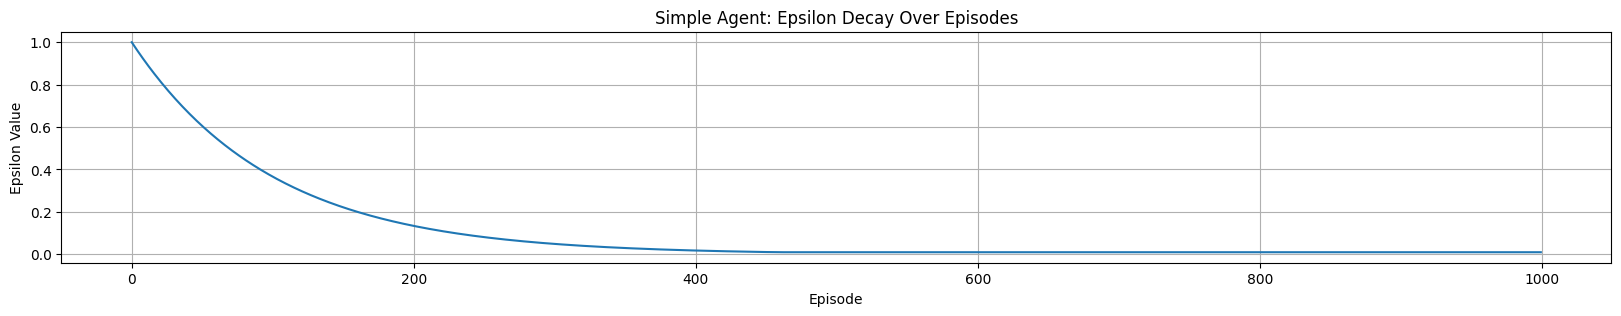

In [12]:
# Plotting epsilon decay
plt.figure(figsize=(20, 3))
plt.plot(simple_episode_epsilons)
plt.title('Simple Agent: Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.grid(True)
plt.show()

**Interpretation:** This plot confirms how the exploration rate ($\epsilon$) decreased over the episodes according to our defined decay schedule. It starts high (encouraging exploration) and gradually lowers (encouraging exploitation of learned knowledge).

### 7.2 Analyzing Agent's Knowledge and Behavior

Let's look deeper into what the agent learned and how it behaves.

#### 7.2.1 State Visitation Frequency
This shows which parts of the grid the agent explored most.

Calculating state visitation counts...


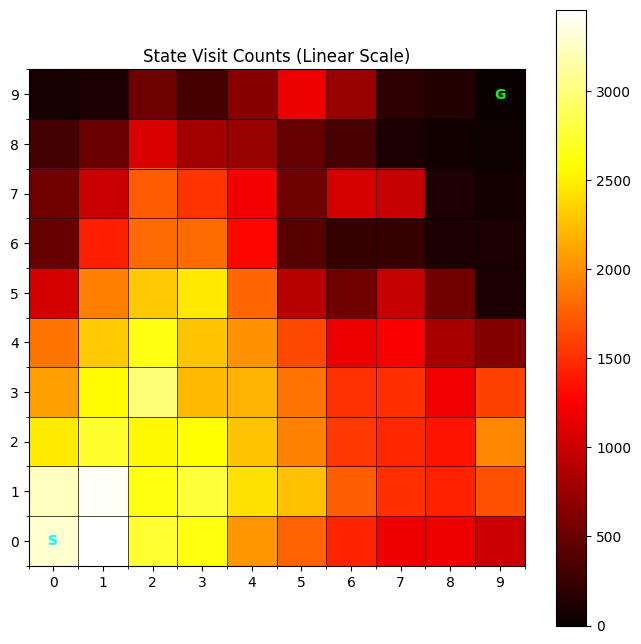

In [13]:
def plot_state_visitation(memory: DefaultDict[Tuple[int, int], DefaultDict[int, List[float]]],
                            env: GridEnvironmentSimple) -> None:
    """ Plots a heatmap of state visitation counts. """
    rows = env.rows
    cols = env.cols
    visit_counts = np.zeros((rows, cols))

    print("Calculating state visitation counts...")
    for state, action_dict in memory.items():
        r, c = state
        total_visits_to_state = sum(len(rewards) for rewards in action_dict.values())
        if 0 <= r < rows and 0 <= c < cols:
             visit_counts[r, c] = total_visits_to_state

    fig, ax = plt.subplots(figsize=(cols * 0.8, rows * 0.8))
    # Use a logarithmic scale if counts vary wildly, otherwise linear
    if np.max(visit_counts) > 10 * np.median(visit_counts[visit_counts > 0]):
         im = ax.imshow(visit_counts + 1e-9, cmap='hot', origin='lower', norm=plt.cm.colors.LogNorm())
         title = "State Visit Counts (Log Scale)"
    else:
         im = ax.imshow(visit_counts, cmap='hot', origin='lower')
         title = "State Visit Counts (Linear Scale)"

    # Add text annotations (optional, can be cluttered)
    # for r in range(rows):
    #     for c in range(cols):
    #         ax.text(c, r, f"{int(visit_counts[r, c])}", ha="center", va="center", color="w" if visit_counts[r,c] > np.max(visit_counts)/2 else "black")

    start_r, start_c = env.start_state
    goal_r, goal_c = env.goal_state
    ax.text(start_c, start_r, 'S', ha='center', va='center', color='cyan', weight='bold')
    ax.text(goal_c, goal_r, 'G', ha='center', va='center', color='lime', weight='bold')

    ax.set_xticks(np.arange(cols))
    ax.set_yticks(np.arange(rows))
    ax.set_xticklabels(np.arange(cols))
    ax.set_yticklabels(np.arange(rows))
    ax.set_xticks(np.arange(-.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-.5, rows, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)
    ax.set_title(title)
    fig.colorbar(im)
    plt.show()

# Plot state visitations
plot_state_visitation(agent_memory_run, env_run)

**Interpretation:** This heatmap shows which grid cells the agent visited most frequently during training. Brighter colors indicate more visits. We can see the paths the agent tended to explore. Ideally, it should show significant exploration, especially early on, and potentially higher concentration along paths leading towards the goal later in training.

#### 7.2.2 Average Immediate Reward Map
This shows the agent's learned estimate of the best *immediate* outcome from each state.

Calculating average rewards for visualization...


/tmp/ipython-input-2795721193.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', 5)  # 5 distinct colors


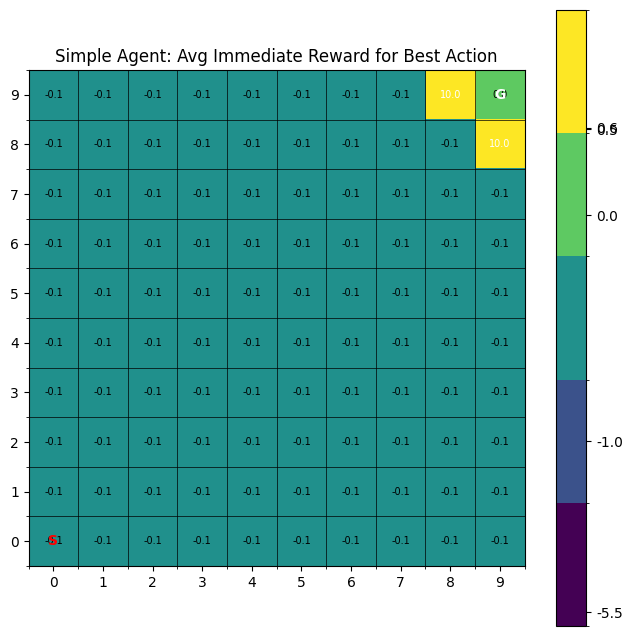

In [14]:
def plot_average_rewards_grid(memory: DefaultDict[Tuple[int, int], DefaultDict[int, List[float]]],
                              env: GridEnvironmentSimple) -> None:
    """ Plots the average immediate reward learned for the best action in each state. """
    rows = env.rows
    cols = env.cols
    avg_reward_grid = np.full((rows, cols), -np.inf) # Initialize with -inf

    print("Calculating average rewards for visualization...")
    for r in range(rows):
        for c in range(cols):
            state = (r, c)
            if state == env.goal_state:
                avg_reward_grid[r, c] = env.step(0)[1] # Use goal reward (e.g., 10)
                continue

            action_values = []
            state_memory = memory[state]
            has_experience = False
            for a in range(env.get_action_space_size()):
                rewards = state_memory[a]
                if rewards:
                     has_experience = True
                     avg_reward = np.mean(rewards)
                     action_values.append(avg_reward)
                else:
                     action_values.append(-np.inf) # Indicate action not tried

            if not has_experience:
                 avg_reward_grid[r, c] = -5 # Assign a distinct low value for unvisited
            else:
                 best_avg_reward = max(action_values)
                 if best_avg_reward == -np.inf:
                     avg_reward_grid[r, c] = -1 # Should not happen if state visited
                 else:
                      avg_reward_grid[r, c] = best_avg_reward

    # Fix the deprecated get_cmap function
    cmap = plt.cm.get_cmap('viridis', 5)  # 5 distinct colors
    bounds = [-6, -1.5, -0.5, -0.05, 0.1, 11] # Define boundaries for colors
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots(figsize=(cols * 0.8, rows * 0.8))
    im = ax.imshow(avg_reward_grid, cmap=cmap, norm=norm, origin='lower')

    # Add text annotations
    for r in range(rows):
        for c in range(cols):
            val = avg_reward_grid[r, c]
            text_val = f"{val:.1f}" if val > -np.inf else "N/A"
            color = "white" if abs(val) > 1 else "black"
            if val == -5: color = "grey"
            ax.text(c, r, text_val, ha="center", va="center", color=color, fontsize=7)

    start_r, start_c = env.start_state
    goal_r, goal_c = env.goal_state
    ax.text(start_c, start_r, 'S', ha='center', va='center', color='red', weight='bold')
    ax.text(goal_c, goal_r, 'G', ha='center', va='center', color='white', weight='bold')

    ax.set_xticks(np.arange(cols))
    ax.set_yticks(np.arange(rows))
    ax.set_xticklabels(np.arange(cols))
    ax.set_yticklabels(np.arange(rows))
    ax.set_xticks(np.arange(-.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-.5, rows, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=0.5)
    ax.set_title("Simple Agent: Avg Immediate Reward for Best Action")

    # Fix the colorbar ticks - create proper list of values
    ticks = [b + 0.5 for b in bounds[:-1]]
    fig.colorbar(im, ticks=ticks, format="%.1f")
    plt.show()

# Plot the learned average rewards
plot_average_rewards_grid(agent_memory_run, env_run)

**Interpretation:** This heatmap shows the agent's learned preference for states based *only* on the best immediate reward experienced from that state. High values (bright colors, near +10) should appear at the goal. States adjacent to walls might show lower values (darker colors, near -1) if the agent frequently bumped into them. States far from walls or the goal might cluster around the step cost (-0.1). 'N/A' or a distinct low value indicates states the agent never (or rarely) experienced choosing an action from.

#### 7.2.3 Derived Greedy Policy Visualization
This shows the action the agent would take in each state if it acted greedily (epsilon=0) based on its memory.

Calculating greedy policy from memory...


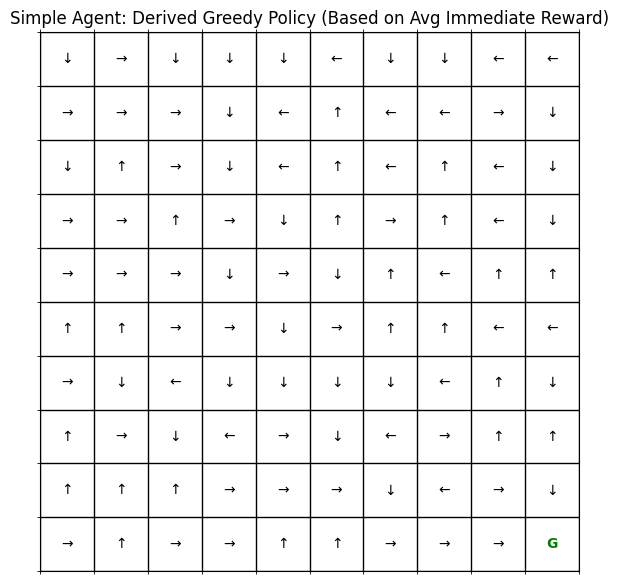

In [15]:
def plot_simple_policy_grid(memory: DefaultDict[Tuple[int, int], DefaultDict[int, List[float]]],
                              env: GridEnvironmentSimple) -> None:
    """ Plots the greedy policy derived from the agent's memory. """
    rows = env.rows
    cols = env.cols
    policy_grid: np.ndarray = np.empty((rows, cols), dtype=str)
    # Action symbols: 0: Up, 1: Down, 2: Left, 3: Right
    action_symbols: Dict[int, str] = {0: '↑', 1: '↓', 2: '←', 3: '→'}

    fig, ax = plt.subplots(figsize=(cols * 0.7, rows * 0.7)) # Adjust size

    print("Calculating greedy policy from memory...")
    for r in range(rows):
        for c in range(cols):
            state = (r, c)
            # Mark goal state
            if state == env.goal_state:
                symbol = 'G'
                color = 'green'
            else:
                # Get the greedy action based on memory (epsilon=0)
                best_action = choose_simple_action(state, memory, epsilon=0.0, n_actions=env.action_dim)

                # Check if the state has any recorded experience
                state_memory = memory[state]
                has_experience = any(state_memory[a] for a in range(env.action_dim))

                if not has_experience:
                    symbol = '.' # Mark unvisited/unexplored states
                    color = 'grey'
                else:
                    symbol = action_symbols[best_action]
                    color = 'black'

            policy_grid[r, c] = symbol
            ax.text(c, r, symbol, ha='center', va='center', color=color, fontsize=10,
                    weight='bold' if symbol == 'G' else 'normal')

    # Plot formatting
    ax.matshow(np.zeros((rows, cols)), cmap='Greys', alpha=0.1) # Light background grid
    ax.set_xticks(np.arange(-.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-.5, rows, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    ax.set_xticks([]) # Hide axis ticks
    ax.set_yticks([])
    ax.set_title("Simple Agent: Derived Greedy Policy (Based on Avg Immediate Reward)")
    plt.show()

# Plot the derived policy
plot_simple_policy_grid(agent_memory_run, env_run)

**Interpretation:** This shows the direction the agent *thinks* is immediately best from each state it has sufficiently explored. Arrows indicate the preferred action. '.' indicates states where the agent has no memory or hasn't tried actions. 'G' is the goal. We might see patterns like moving away from walls, but a coherent path to the goal is unlikely because the agent doesn't consider long-term consequences.

#### 7.2.4 Action Selection Frequency (Example State)
Let's see how often each action was chosen from the start state `(0,0)`.

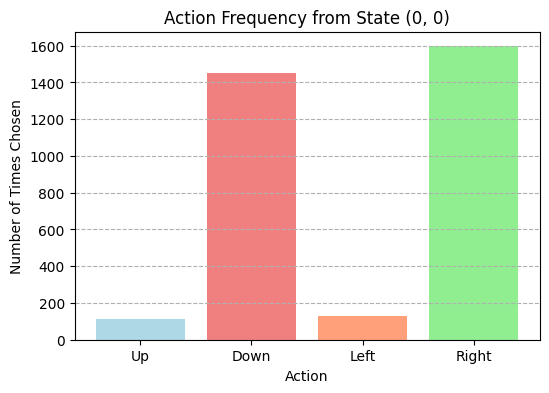

In [16]:
def plot_action_frequency(memory: DefaultDict[Tuple[int, int], DefaultDict[int, List[float]]],
                          state_to_analyze: Tuple[int, int],
                          n_actions: int) -> None:
    """ Plots a bar chart of how often each action was taken from a specific state. """
    action_counts = [len(memory[state_to_analyze][a]) for a in range(n_actions)]
    action_labels = ['Up', 'Down', 'Left', 'Right'] # Assuming 0=U, 1=D, 2=L, 3=R

    plt.figure(figsize=(6, 4))
    plt.bar(action_labels, action_counts, color=['lightblue', 'lightcoral', 'lightsalmon', 'lightgreen'])
    plt.title(f'Action Frequency from State {state_to_analyze}')
    plt.xlabel('Action')
    plt.ylabel('Number of Times Chosen')
    plt.grid(axis='y', linestyle='--')
    plt.show()

# Plot action frequency for the start state
start_state = env_run.start_state
plot_action_frequency(agent_memory_run, start_state, n_actions_run)

**Interpretation:** This bar chart shows the raw counts of how many times each action was selected when the agent was in the specified state (here, the start state). Early in training (high epsilon), counts might be similar due to random exploration. Later, if the agent developed preferences based on immediate rewards, some bars might be significantly higher than others.

#### 7.2.5 Convergence of Average Reward (Example State-Action)
Let's track how the agent's estimate of the average immediate reward for a specific state-action pair changed over time.


Analyzing rewards for State=(1, 1), Action=3:


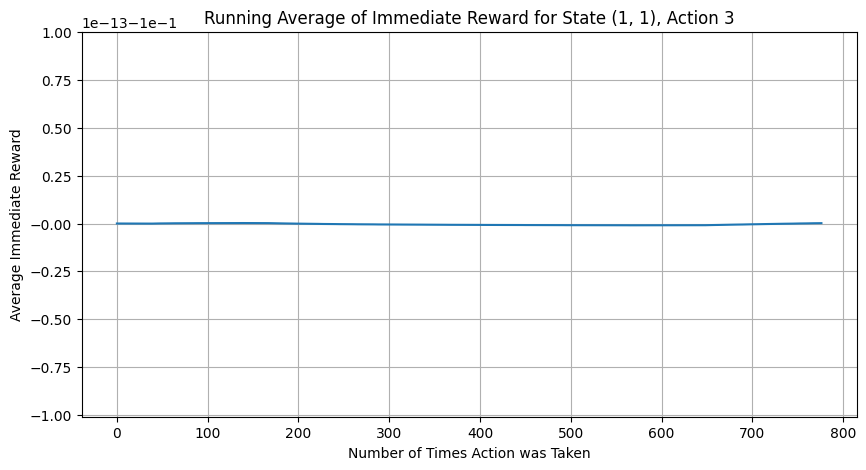

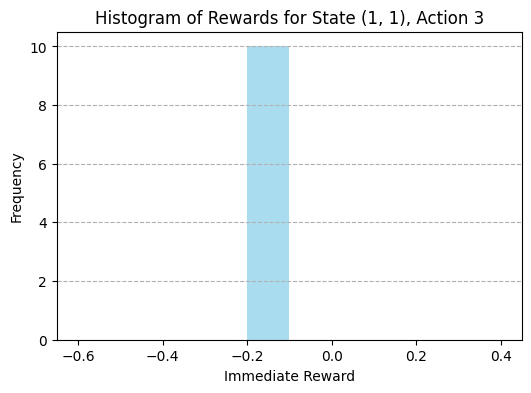

In [17]:
def plot_reward_convergence(memory_history: List[DefaultDict[Tuple[int, int], DefaultDict[int, List[float]]]],
                            state_to_analyze: Tuple[int, int],
                            action_to_analyze: int) -> None:
    """ Plots the running average reward for a specific state-action pair over episodes. """

    avg_rewards_over_time = []
    total_rewards_so_far = 0.0
    count = 0

    # Need to re-run or store memory snapshots during training for this plot.
    # Let's approximate by recalculating from the final memory (less accurate over time view).
    # A better approach would store snapshots or recalculate running means during training.

    # --- Approximation using final memory ---
    # This shows the final distribution, not convergence path
    rewards_list = memory_history[-1][state_to_analyze][action_to_analyze]
    if not rewards_list:
        print(f"No data recorded for State {state_to_analyze}, Action {action_to_analyze}")
        return

    running_averages = []
    current_sum = 0.0
    for i, reward in enumerate(rewards_list):
        current_sum += reward
        running_averages.append(current_sum / (i + 1))

    plt.figure(figsize=(10, 5))
    plt.plot(running_averages)
    plt.title(f'Running Average of Immediate Reward for State {state_to_analyze}, Action {action_to_analyze}')
    plt.xlabel('Number of Times Action was Taken')
    plt.ylabel('Average Immediate Reward')
    plt.grid(True)
    plt.show()

# We need memory snapshots to plot true convergence.
# Storing the final memory allows plotting the estimate distribution.
example_state = (1, 1)
example_action = 3 # Right
print(f"\nAnalyzing rewards for State={example_state}, Action={example_action}:")
plot_reward_convergence([agent_memory_run], example_state, example_action)

# Additionally, let's plot a histogram of received rewards for that pair
rewards_list_final = agent_memory_run[example_state][example_action]
if rewards_list_final:
    plt.figure(figsize=(6, 4))
    plt.hist(rewards_list_final, bins=10, density=True, alpha=0.7, color='skyblue')
    plt.title(f'Histogram of Rewards for State {example_state}, Action {example_action}')
    plt.xlabel('Immediate Reward')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--')
    plt.show()
else:
     print(f"No data recorded for State {example_state}, Action {example_action}")

**Interpretation:** The line plot shows how the agent's *estimate* of the average immediate reward for taking a specific action (Right) in a specific state ((1,1)) changes as it experiences that situation more often. Ideally, this average should converge to the true expected immediate reward for that state-action pair (which is -0.1 in this case, unless it leads directly to the goal or a wall from that state). The histogram shows the distribution of rewards actually received for that pair. In our deterministic environment, it should ideally be a single bar at -0.1 (or -1 or +10 if applicable).

